

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.



## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [10]:
%pylab inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['median']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Магистратура/4 cем/ПОСИИ/ПР2/Train_rev1.csv')


In [7]:
data.head(2)



,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [6]:
print(data.shape)

(244768, 12)


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

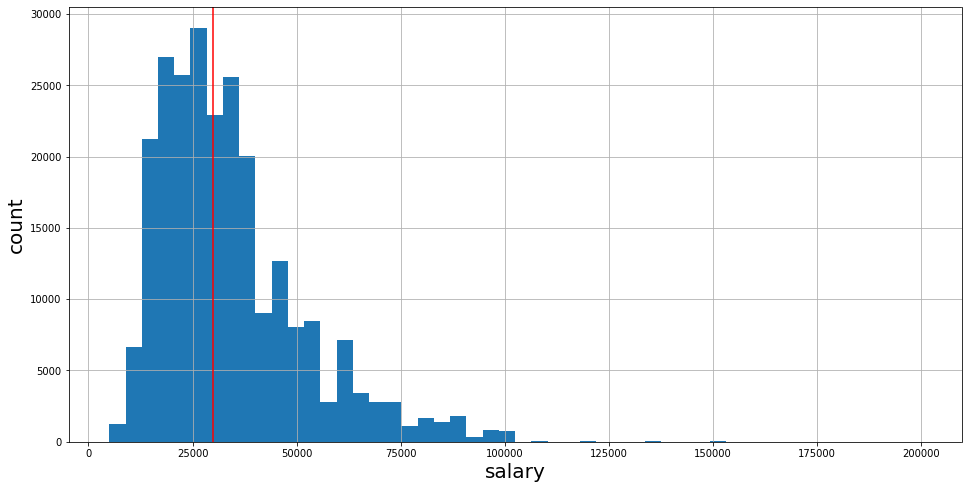

In [11]:
# salary histogramm
median = np.median(data['SalaryNormalized'])

figsize(16,8)
plt.hist(data['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [12]:
data['SalaryNormalized'] = (data['SalaryNormalized'] > median).astype(int)
data.drop('SalaryRaw', axis=1, inplace=True)
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [54]:
'''
random_state - сид для псевдослучайного генератора
недетерминированные операции на одних и тех же данных с одним и тем же random_state дают один и тот же результат
'''

from sklearn.model_selection import train_test_split

Y = data['SalaryNormalized']
X = data.drop('SalaryNormalized', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Вывод размерностей полученных выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер контрольной выборки:", X_test.shape)

Размер обучающей выборки: (171337, 10)
Размер контрольной выборки: (73431, 10)


In [52]:
#Табличное представление обучающей выборки дата
X_train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
241453,72676065,Business Development Executive ****k plus bonus,Business Development Executive Dudley Permanen...,"Dudley, West Midlands (County) West Midlands (...",UK,NaN,permanent,Anderson Scott Solutions,Sales Jobs,totaljobs.com
169520,71341050,English Teacher,"English Teacher Permanent, Fulltime contract ...",Avon,Avon,full_time,contract,ITN Mark Education Bristol,Teaching Jobs,jobsineducation.co.uk
136661,70336585,EMEA Customer Service Project Coordinator,Excellent opportunity to join a successful glo...,Oxford,Oxford,full_time,NaN,Bluestream Recruitment,Customer Services Jobs,careerbuilder.com
125435,69992269,Administrator / Receptionist,Acting as a recruitment business on behalf of ...,Leeds West Yorkshire Yorkshire,Leeds,NaN,contract,Taskmaster,Admin Jobs,totaljobs.com
192568,71760157,Business Analyst / Product Owner to ****k,Business Analyst / Product Owner This is an ex...,London South East,South East London,NaN,permanent,The Industry Club,IT Jobs,cwjobs.co.uk


In [55]:
#Табличное представление меток
y_train.head()

241453    0
169520    0
136661    0
125435    0
192568    1
Name: SalaryNormalized, dtype: int64

## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [56]:
# Объединение значений признаков каждого объекта через пробел для обучающей выборки
train_text = X_train.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# Объединение значений признаков каждого объекта через пробел для контрольной выборки
test_text = X_test.apply(lambda row: ' '.join(row.astype(str)), axis=1)

from sklearn.feature_extraction.text import CountVectorizer

# Создание экземпляра CountVectorizer
vectorizer = CountVectorizer()

# Применение CountVectorizer на обучающей выборке
X_train = vectorizer.fit_transform(train_text)

# Применение CountVectorizer на контрольной выборке
X_test = vectorizer.transform(test_text)

In [58]:
print("Пример train_text:")
print(train_text[0])

Пример train_text:
12612628 Engineering Systems Analyst Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our client provides specialist software development Keywords Mathematical Modelling, Risk Analysis, System Modelling, Optimisation, MISER, PIONEEER Engineering Systems Analyst Dorking Surrey Salary ****K Dorking, Surrey, Surrey Dorking nan permanent Gregory Martin International Engineering Jobs cv-library.co.uk


#### 3. Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [62]:
from sklearn.linear_model import LogisticRegression

# создание объекта LogisticRegression с параметрами по умолчанию
lr = LogisticRegression()

# обучение модели на обучающей выборке
lr.fit(X_train, y_train)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:450: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  opt_res = optimize.minimize(


LogisticRegression()

In [70]:
!pip install vowpalwabbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 17.8 MB/s eta 0:00:00


In [71]:
from vowpalwabbit.sklearn import VWClassifier
logreg_vw = VWClassifier(random_seed=42)
logreg_vw.fit(X_train, y_train)

VWClassifier(classes_: [0 1], coef_: , convert_labels: True, convert_to_vw: True, loss_function: logistic, passes: 1, quiet: True, random_seed: 42, vw_: <vowpalwabbit.pyvw.Workspace object at 0x7f8e41952cc0>)

#### 4. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [72]:
#Предикты VW и SKL
y_pred_sklearn = lr.predict(X_test)
y_pred_vw = logreg_vw.predict(X_test)

In [74]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

#Метрики SKL
roc_auc_sklearn = roc_auc_score(y_test, y_pred_sklearn)
f1_sklearn = f1_score(y_test, y_pred_sklearn)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)

#Метрики VW
roc_auc_vw = roc_auc_score(y_test, y_pred_vw)
f1_vw = f1_score(y_test, y_pred_vw)
cm_vw = confusion_matrix(y_test, y_pred_vw)

print('Модель из sklearn:')
print('ROC-AUC:', roc_auc_sklearn)
print('F-мера:', f1_sklearn)
print('Матрица ошибок:\n', cm_sklearn)
print('-------------------------------------')
print('Модель из Vowpal Wabbit:')
print('ROC-AUC:', roc_auc_vw)
print('F-мера:', f1_vw)
print('Матрица ошибок:\n', cm_vw)

Модель из sklearn:
ROC-AUC: 0.8593297628879073
F-мера: 0.8546351084812622
Матрица ошибок:
 [[32782  5158]
 [ 5160 30331]]
-------------------------------------
Модель из Vowpal Wabbit:
ROC-AUC: 0.8671475778745841
F-мера: 0.8625569680978652
Матрица ошибок:
 [[33124  4816]
 [ 4925 30566]]


#### 5. Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [ ]:
# Your code here

#### 6. Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [ ]:
# Your code here

#### 8.  Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [ ]:
# Your code here

#### 9. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [ ]:
# Your code here

#### 10. Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:

#### 11.  Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

#### 12. Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [ ]:
# Your code here

#### 14. Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [ ]:
# Your code here

#### 15. Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

In [ ]:
# Your code here

#### 16.  Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

## Подбор гиперпараметров

#### 17. Разбейте обучающую выборку, полученную в п. 13, на обучающую и валидационную в отношении 80/20, после чего подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here